In [1]:
# Objective is to link up the devon dataset with a PV system in the area
# start off with predicting PV based on image, not including time series aspect

# Potentially useful tutorial here https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed
# Illinois converting data to numpy https://github.com/jmather625/climatehack/blob/main/data/download_data.ipynb

### 1. Importing data

In [1]:
import numpy as np
import datetime
import pandas as pd
import xarray as xr
import tqdm
import matplotlib.pyplot as plt
from PIL import Image as im

#### PV yield

In [7]:
pv_power = xr.open_dataset("data/uk_pv/pv.netcdf", engine="h5netcdf")
# PV yield is every 5 minutes, from 2018-01-01 to 2021-10-27, from 6am to 7pm

devon_pv_df = pv_power['6848'].to_dataframe()

# cropping for 2020-01-01 to 2021-11-07

devon_pv_df = devon_pv_df[devon_pv_df.index < '2020-12-30']
devon_pv_df = devon_pv_df[devon_pv_df.index > '2020-01-01']

#devon_pv_df.drop(columns=1)
pv_times_list = devon_pv_df.index.tolist()
print('Number of PV readings :', len(pv_times_list))

Number of PV readings : 104532


#### Sat images

In [2]:
# I then cropped the satellite dataset using time-crop.ipnyb to get only PV images between 06:00 and 20:00

# sat_times: a numpy array of timestamps for PV data between 06:00 and 20:00
# pv_slices: a numpy array of PV data for the associated timestamps above

In [3]:
# Loading the satellite reading *times* in 2020

cropped_sat_times = np.load('data/sat_times_2020.npy')
cropped_sat_times_list = cropped_sat_times.tolist()

# convert back to datetime format (since changed into int when it was converted into numpy)
for i in range(len(cropped_sat_times_list)):
    cropped_sat_times_list[i] = np.datetime64(cropped_sat_times_list[i],"ns")

len(cropped_sat_times) # we have 50K sat_times

55787

In [11]:
# Loading the satellite reading *data* for 2020 (1GB file)
sat_data = np.load('data/sat_slices_2020.npy')

print(sat_data.shape)
print(cropped_sat_times_list[0])
print('Number of satellite images in period :', len(sat_data))

(55787, 100, 100)
2020-01-01T06:00:00.000000000
Number of satellite images in period : 55787


#### Do we have PV readings for all sat images?

In [11]:
# Create a dataset where the timestamp is the same between both

def create_timecropped_pv_dataset(n):

    pv_readings = []
    sat_images = []

    for time in tqdm.tqdm(pv_times_list[:n]):
        if time in cropped_sat_times_list[:n]:
            # Add the PV reading for that time
            pv_readings.append(devon_pv_df[devon_pv_df.index == time])
            
            # Add the satellite image 
            
            # Find which observation relates to this timestamp
            sat_obs_number = cropped_sat_times_list.index(time)
            sat_images.append(sat_data[sat_obs_number])


    np.save('data/sat_images_2020_devon_timecropped_scaled', sat_images)
    np.save('data/pv_yield_2020_devon_timecropped', pv_readings)


create_timecropped_pv_dataset(10000)


100%|██████████| 20000/20000 [15:45<00:00, 21.15it/s] 


In [45]:
# Just took the first 10,000 from each list, it was taking a long time otherwise

sat_images = np.load('data/sat_images_2020_devon_timecropped_scaled.npy')
pv_readings = np.load('data/pv_yield_2020_devon_timecropped.npy')
pv_readings = pv_readings.flatten()

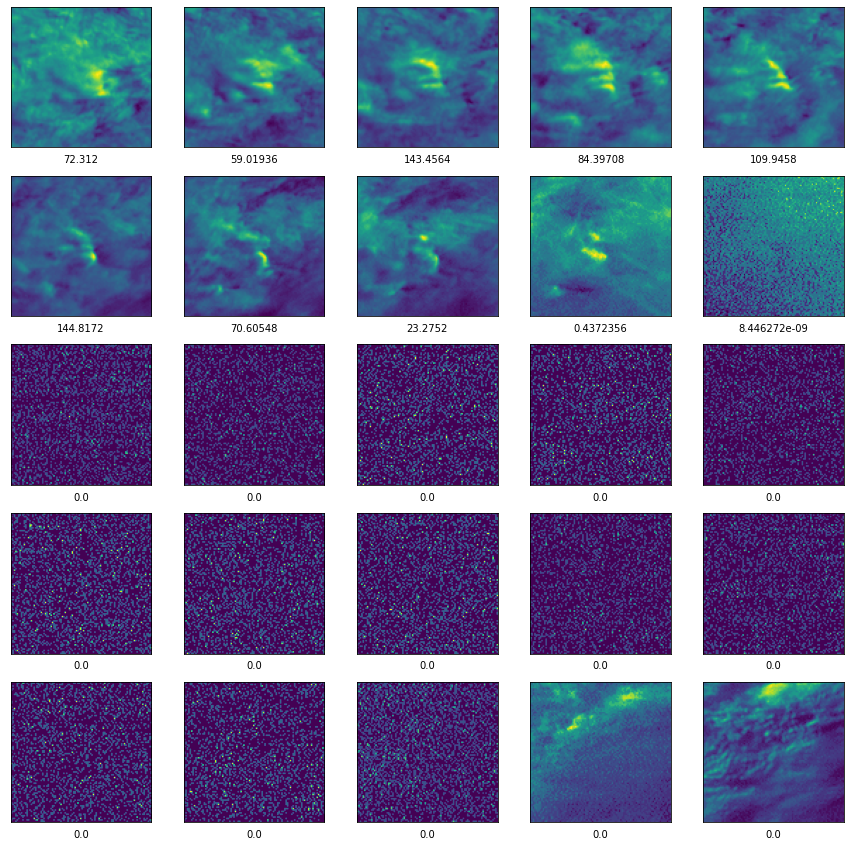

In [46]:

def print_grid(n):

    max = np.nanmax(pv_readings)

    plt.figure(figsize=(15,15))
    for i in range(0,25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(sat_images[i*5+n])
        plt.xlabel(pv_readings[i*5+n])
    plt.show()

print_grid(250)

In [54]:
sat_images_scaled = sat_images / 255

In [63]:
# This takes in pv_readings and sat_images as arrays, and gets them ready for the model
# First it scales the images, then drops images and readings where the value is 0

def datapipeline(sat_images, pv_readings):

    # printing information
    print('Inputs')
    print('Dataset sizes: pv_readings -', len(pv_readings), ', sat_images -', len(sat_images))
    print('Dataset dimensions: pv_readings -', pv_readings.shape, ', sat_images -', sat_images.shape)
    
    
    # Rescale the images from [0,255] to [0,1] 
    sat_images_scaled = sat_images / 255

    # Rescale the pv_readings from [0, max] to [0,1]
    pv_readings_scaled = pv_readings / (np.nanmax(pv_readings) +1) # scaling the PV, making this slightly bigger so range is between 0 and 1

    print('Data and labels rescaled to [0,1]')

    # Dropping images and pv readings where the reading is 0 (where satellite is offline?)
    drop_pv_readings = []
    drop_sat_images_scaled = []

    i = 0
    for i in range(len(pv_readings_scaled)):
        if pv_readings_scaled[i] > 0.001:
            drop_pv_readings.append(pv_readings_scaled[i])
            drop_sat_images_scaled.append(sat_images_scaled[i])

    drop_pv_readings = np.array(drop_pv_readings)
    drop_sat_images_scaled = np.array(drop_sat_images_scaled) 

    # printing information
    print('PV readings of zero dropped. \nRemaining dataset:')
    print('Dataset sizes: pv_readings -', len(drop_pv_readings), ', sat_images -', len(drop_sat_images_scaled))
    print('Dataset dimensions: pv_readings -', drop_pv_readings.shape, ', sat_images -', drop_sat_images_scaled.shape)


    # Resize the images to be 32x32, taking drop_sat_images_scaled
    drop_sat_images_scaled_resized = []

    for i in range(len(drop_sat_images_scaled)):
        image = im.fromarray(drop_sat_images_scaled[i])
        image_resized = image.resize((100,100))
    
        drop_sat_images_scaled_resized.append(np.array(image_resized))

    drop_sat_images_scaled_resized = np.array(drop_sat_images_scaled_resized)

    # printing information
    print('Images resized. \nRemaining dataset:')
    print('Dataset sizes: pv_readings -', len(drop_pv_readings), ', sat_images -', len(drop_sat_images_scaled_resized))
    print('Dataset dimensions: pv_readings -', drop_pv_readings.shape, ', sat_images -', drop_sat_images_scaled_resized.shape)

    return drop_sat_images_scaled_resized, drop_pv_readings


In [64]:
X,y = datapipeline(sat_images, pv_readings)

Inputs
Dataset sizes: pv_readings - 6899 , sat_images - 6899
Dataset dimensions: pv_readings - (6899,) , sat_images - (6899, 100, 100)
Data and labels rescaled to [0,1]
PV readings of zero dropped. 
Remaining dataset:
Dataset sizes: pv_readings - 4539 , sat_images - 4539
Dataset dimensions: pv_readings - (4539,) , sat_images - (4539, 100, 100)
Images resized. 
Remaining dataset:
Dataset sizes: pv_readings - 4539 , sat_images - 4539
Dataset dimensions: pv_readings - (4539,) , sat_images - (4539, 100, 100)


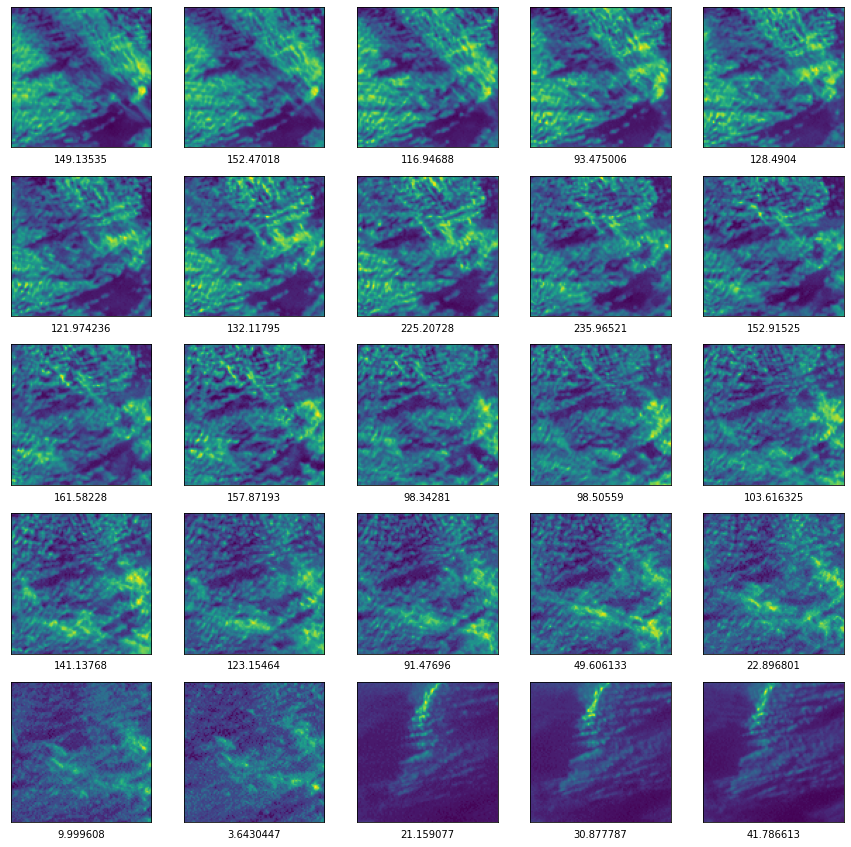

In [65]:
# Comparing PV measurements, matched with images

def print_prepared_grid(n):

    max = np.nanmax(pv_readings)

    plt.figure(figsize=(15,15))
    for i in range(0,25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i+n])
        plt.xlabel(y[i+n]*max)
    plt.show()

print_prepared_grid(600)

#### Training a model 

In [66]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(X, y, random_state=42)

In [67]:
len(train_images)

3404

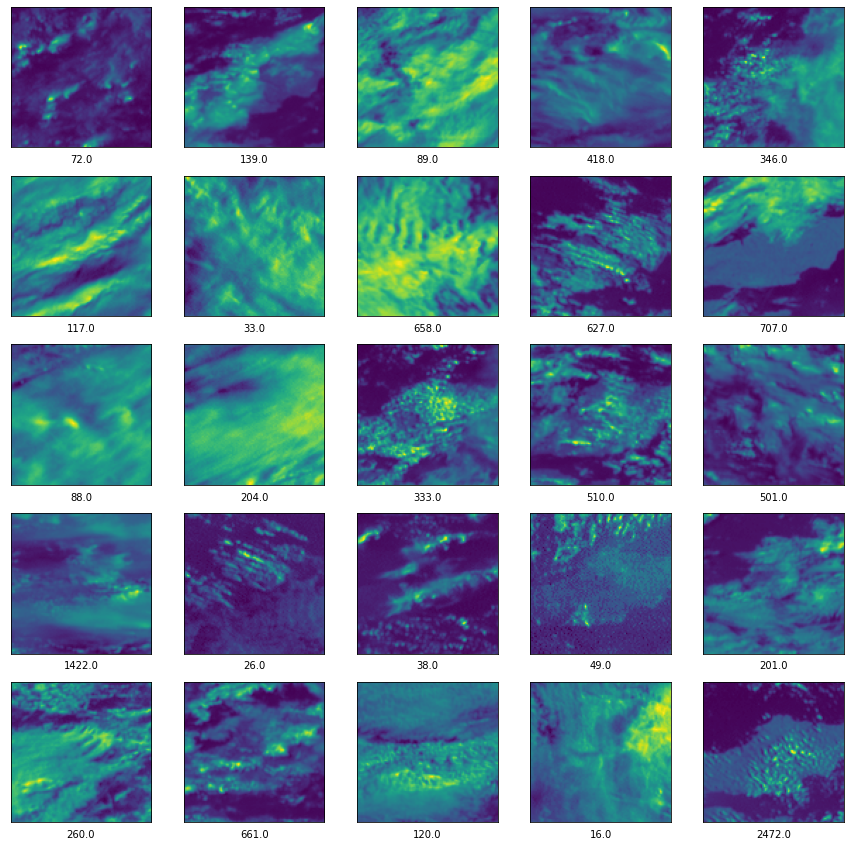

In [68]:
# Getting quite a few where image is distorted - suspect this is when datafeed is offline

max = np.nanmax(pv_readings)

plt.figure(figsize=(15,15))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+20])
    plt.xlabel(round(train_labels[i+20]*max,0))
plt.show()

In [69]:
# tf tutorial https://www.tensorflow.org/tutorials/images/cnn

import tensorflow as tf
import keras

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [70]:
model.compile(optimizer='adam',loss='mse')


history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

                    

Epoch 1/10
107/107 [==============================] - 37s 337ms/step - loss: 0.3798 - val_loss: 0.0203
Epoch 2/10
107/107 [==============================] - 39s 370ms/step - loss: 0.0200 - val_loss: 0.0220
Epoch 3/10
107/107 [==============================] - 37s 351ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 4/10
107/107 [==============================] - 41s 388ms/step - loss: 0.0142 - val_loss: 0.0159
Epoch 5/10
107/107 [==============================] - 42s 389ms/step - loss: 0.0127 - val_loss: 0.0165
Epoch 6/10
107/107 [==============================] - 40s 370ms/step - loss: 0.0113 - val_loss: 0.0143
Epoch 7/10
107/107 [==============================] - 36s 337ms/step - loss: 0.0096 - val_loss: 0.0139
Epoch 8/10
107/107 [==============================] - 42s 392ms/step - loss: 0.0086 - val_loss: 0.0140
Epoch 9/10
107/107 [==============================] - 44s 405ms/step - loss: 0.0074 - val_loss: 0.0129
Epoch 10/10
107/107 [==============================] - 39s 368ms/step - l

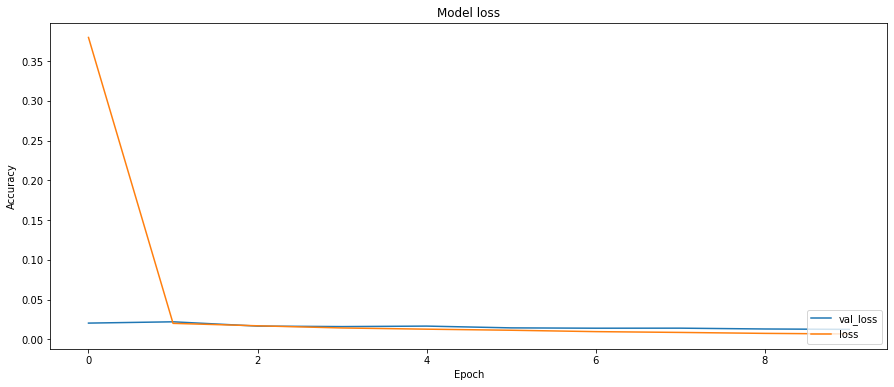

In [83]:
plt.figure(figsize=(15,6))
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model loss');

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [84]:
model.evaluate(test_images,  test_labels, verbose=2)

36/36 - 2s - loss: 0.0124 - 2s/epoch - 67ms/step


0.012448079884052277

In [87]:
X[0].shape

(100, 100)

In [94]:
X[0].reshape(1,100,100,1)

dtype('float32')

In [92]:
tf.convert_to_tensor(X[0]).shape

TensorShape([100, 100])

In [108]:
len(y)

4539

In [109]:
# Predicting

predictions = []
truth = []

for i in range(0,len(y)):
    predictions.append(model.predict(X[i].reshape(1,100,100,1), verbose=0)[0][0])
    truth.append(y[i])

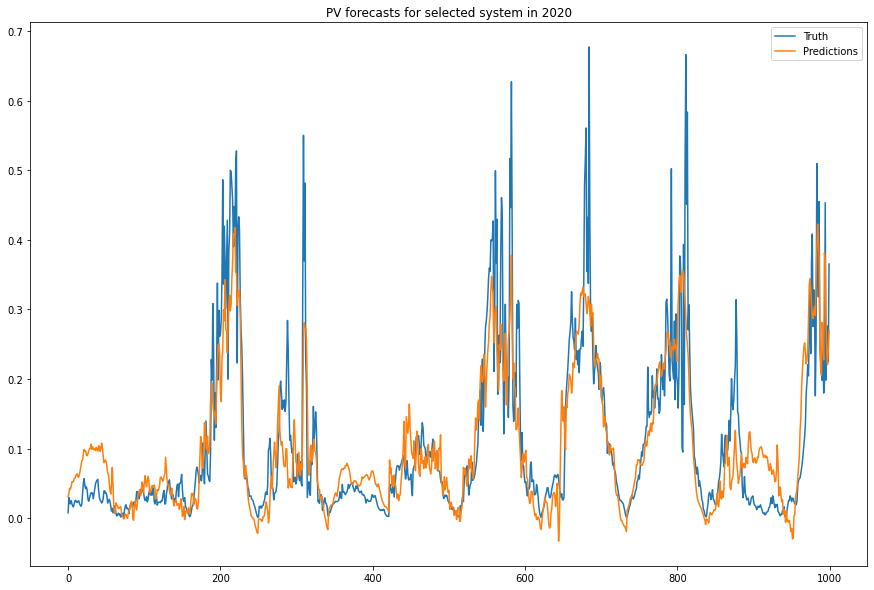

In [116]:
plt.figure(figsize=(15,10))
plt.plot(truth[:1000], label='Truth')
plt.plot(predictions[:1000], label='Predictions')
plt.legend()
plt.title('PV forecasts for selected system in 2020');
plt.savefig('images/first_test_predictions.jpg')

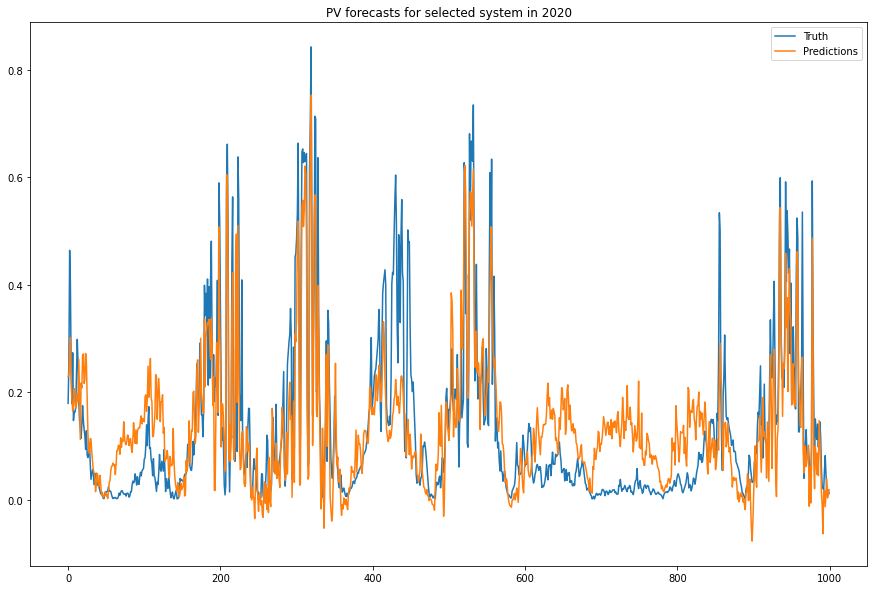

In [115]:
plt.figure(figsize=(15,10))
plt.plot(truth[1000:2000], label='Truth')
plt.plot(predictions[1000:2000], label='Predictions')
plt.legend()
plt.title('PV forecasts for selected system in 2020');
plt.savefig('images/first_test_predictions_2.jpg')